In [2]:
import sys
import os
path = os.path.abspath("lib")
sys.path.append(path)

In [3]:
import numpy as np
import al_sus as al
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import pywt
import pywt.data

from scipy import sparse
from scipy.sparse import coo_matrix
from scipy.optimize import curve_fit

from matplotlib.colors import LogNorm, Normalize
import seaborn as sns

import pandas as pd
from scipy.stats import entropy as stats_entropy

from skimage.metrics import structural_similarity as ssim

import time
from dyson_copy import Sigma
import al as al_se

In [4]:
from matplotlib.font_manager import findfont, FontProperties
import matplotlib.font_manager as font_manager
font = FontProperties(fname='.fonts//cmunrm.ttf')
font_manager._rebuild()

Fontconfig warning: ignoring UTF-8: not a valid region tag


# Quantification of Compression

In [3]:
betas = np.array([10,100,1000])
threshold_quantiles = np.array([0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99])
niwf = 256
u = 1
levels = np.arange(1, pywt.dwt_max_level(niwf, "haar")+1)

In [4]:
data = pd.DataFrame(
                columns=['beta', 'threshold_quantile', 'level', 'mse_spin', 'mse_charge', 'sus_spin', 'sus_charge',
                         'compression_spin', 'compression_charge', 'reconstruction_spin', 'reconstruction_charge',
                         'ssim_spin', 'ssim_charge'
                        ])

for bidx, beta in enumerate(betas):
    chi_spin = al.chi_s(u, beta, u/2, niwf).real
    chi_charge = al.chi_c(u, beta, u/2, niwf).real
    
    for tidx, threshold_quantile in enumerate(threshold_quantiles):
        print(f"{threshold_quantile}")
        for lidx, level in enumerate(levels):
            
            a = np.int32(niwf/(2**(level-1)))
    
            coeffs_c = pywt.wavedec2(chi_charge,'haar',level=level)
            coeff_c_arr,coeff_c_slices = pywt.coeffs_to_array(coeffs_c)

            coeffs_s = pywt.wavedec2(chi_spin,'haar',level=level)
            coeff_s_arr,coeff_s_slices = pywt.coeffs_to_array(coeffs_s)

            c_details = np.concatenate((coeff_c_arr[a:,:].flatten(), coeff_c_arr[:a,a:].flatten()))
            s_details = np.concatenate((coeff_s_arr[a:,:].flatten(), coeff_s_arr[:a,a:].flatten()))

            thresh_c = np.quantile(np.abs(c_details), threshold_quantile)
            thresh_s = np.quantile(np.abs(s_details), threshold_quantile)

            approx_c = np.copy(coeff_c_arr[:a,:a])
            coeff_c_arr_rec = (np.abs(coeff_c_arr[:,:]) > thresh_c) * coeff_c_arr[:,:]
            coeff_c_arr_rec[:a,:a] = np.copy(approx_c)

            approx_s = np.copy(coeff_s_arr[:a,:a])
            coeff_s_arr_rec = (np.abs(coeff_s_arr[:,:]) > thresh_s) * coeff_s_arr[:,:]
            coeff_s_arr_rec[:a,:a] = np.copy(approx_s)
            
            sp_rec_s = coo_matrix(coeff_s_arr_rec)
            sp_rec_c = coo_matrix(coeff_s_arr_rec)
                        
            compression_spin = 1 - (sp_rec_s.data.nbytes + sp_rec_s.row.nbytes + sp_rec_s.col.nbytes)/coeff_s_arr_rec.nbytes
            compression_charge = 1 - (sp_rec_c.data.nbytes + sp_rec_c.row.nbytes + sp_rec_c.col.nbytes)/coeff_c_arr_rec.nbytes

            chi_charge_rec = pywt.waverec2(pywt.array_to_coeffs(coeff_c_arr_rec,coeff_c_slices,output_format='wavedec2'),'haar')
            chi_spin_rec   = pywt.waverec2(pywt.array_to_coeffs(coeff_s_arr_rec,coeff_s_slices,output_format='wavedec2'),'haar')
            
            sus_spin = np.sum(1/beta**2 * chi_spin_rec)
            sus_charge = np.sum(1/beta**2 * chi_spin_rec)
            
            mse_spin = np.mean(np.square(chi_spin - chi_spin_rec))
            mse_charge = np.mean(np.square(chi_charge - chi_charge_rec))
            
            ssim_spin = ssim(chi_spin, chi_spin_rec, multichannel=False)
            ssim_charge = ssim(chi_charge, chi_charge_rec, multichannel=False)
            
            data = data.append({'beta': beta, 
                                'threshold_quantile': threshold_quantile, 
                                'level': level,
                                'mse_spin': mse_spin,
                                'mse_charge': mse_charge,
                                'sus_spin': sus_spin,
                                'sus_charge': sus_charge,
                                'compression_spin': compression_spin,
                                'compression_charge': compression_charge,
                                'reconstruction_spin': chi_spin_rec,
                                'reconstruction_charge': chi_charge_rec,
                                'ssim_spin': ssim_spin,
                                'ssim_charge': ssim_charge
                               },
                   ignore_index=True)

0.9


/var/folders/f3/5mwmxdln2t587p3x9czmpc3c0000gn/T/ipykernel_1736/685139960.py:52: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_spin = ssim(chi_spin, chi_spin_rec, multichannel=False)
/var/folders/f3/5mwmxdln2t587p3x9czmpc3c0000gn/T/ipykernel_1736/685139960.py:53: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_charge = ssim(chi_charge, chi_charge_rec, multichannel=False)


0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99


### Plot of original susceptibility

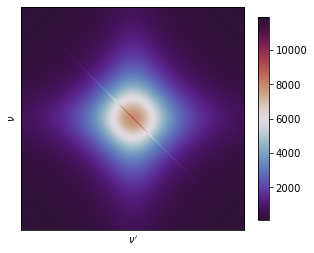

In [5]:
fig, ax = plt.subplots(figsize=(5,5))
chi_spin = al.chi_s(u, 1000, u/2, niwf).real
im = ax.imshow(chi_spin, cmap="twilight_shifted")
fig.colorbar(im, ax=ax, shrink=0.75)

# remove ticks
ax.set_xticks([])
ax.set_yticks([])

# set labels
ax.set_xlabel(r"$\nu'$")
ax.set_ylabel(r"$\nu$")

plt.savefig('graphics/compr_original.pdf', bbox_inches='tight')

### Plot of compressed susceptibility

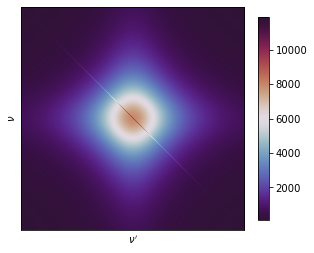

In [6]:
beta = 1000
level = 8
threshold = 0.95

fig, ax = plt.subplots(figsize=(5,5))
pltdata = data[(data['beta'] == beta) & (data['level'] == level) & (data['threshold_quantile'] == threshold)]['reconstruction_spin'].values[0]
im = ax.imshow(pltdata, cmap="twilight_shifted")
fig.colorbar(im, ax=ax, shrink=0.75)

# remove ticks
ax.set_xticks([])
ax.set_yticks([])

# set labels
ax.set_xlabel(r"$\nu'$")
ax.set_ylabel(r"$\nu$")

plt.savefig(f'graphics/compr_rec_beta{beta}_l{level}_th{int(threshold*100)}.pdf')

### Plot of difference between original and compressed vertices

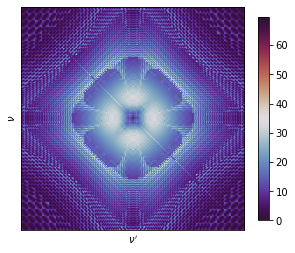

In [7]:
beta = 1000
level = 8
threshold = 0.95

fig, ax = plt.subplots(figsize=(5,5))
pltdata = data[(data['beta'] == beta) & (data['level'] == level) & (data['threshold_quantile'] == threshold)]['reconstruction_spin'].values[0]
im = ax.imshow(np.abs(pltdata-chi_spin), cmap="twilight_shifted")
fig.colorbar(im, ax=ax, shrink=0.75)

# remove ticks
ax.set_xticks([])
ax.set_yticks([])

# set labels
ax.set_xlabel(r"$\nu'$")
ax.set_ylabel(r"$\nu$")

plt.savefig(f'graphics/compr_rec_beta{beta}_l{level}_th{int(threshold*100)}_diff.pdf')

### Batch generation of heatmaps for compression ratio and SSIM

In [8]:
for q in ['spin', 'charge']:
    for beta in betas:
        for val in ['compression', 'ssim']:
            plt.clf()
            # Customize everything else to default font settings
            plt.rcParams['figure.figsize'] = 6,4

            heatmap_data = data[data['beta'] == beta].pivot_table(values=f'{val}_{q}', index='threshold_quantile', columns='level')
            heatmap_data.index = heatmap_data.index.set_names(['thresholdquantile'])

            # Change heatmap annotation font to default
            ax = sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3f')

            for label in ax.get_xticklabels() + ax.get_yticklabels():
                label.set_fontproperties(font)
                label.set_fontsize(16)

            # Get the colorbar
            cbar = ax.collections[0].colorbar

            # Set tick label font properties for colorbar
            for label in cbar.ax.get_yticklabels():
                label.set_fontproperties(font)
                label.set_fontsize(16)

            # Set the labels
            plt.xlabel('Decomposition Level', fontproperties=font, fontsize=18)
            plt.ylabel('Threshold Quantile', fontproperties=font, fontsize=18)

            plt.savefig(f'graphics/heatmap_{val}_{q}_{beta}.pdf', bbox_inches='tight')
            plt.clf()

<Figure size 432x288 with 0 Axes>

### Test generation of a single heatmap to check style

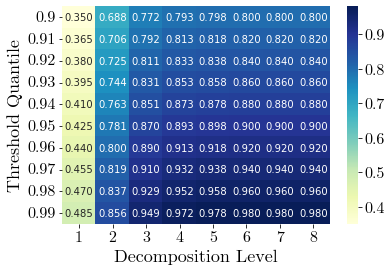

In [9]:
q = "spin"
b = 100
val = "compression"

# Customize everything else to default font settings
plt.rcParams['figure.figsize'] = 6,4

heatmap_data = data[data['beta'] == beta].pivot_table(values=f'{val}_{q}', index='threshold_quantile', columns='level')
heatmap_data.index = heatmap_data.index.set_names(['thresholdquantile'])

ax = sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3f')

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(font)
    label.set_fontsize(16)

# Get the colorbar
cbar = ax.collections[0].colorbar

# Set tick label font properties for colorbar
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(font)
    label.set_fontsize(16)

# Set the labels
plt.xlabel('Decomposition Level', fontproperties=font, fontsize=18)
plt.ylabel('Threshold Quantile', fontproperties=font, fontsize=18)
# Save the figure
plt.show()

# Some more imports

In [17]:
import scienceplots

plt.style.use(['default'])
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['lines.markersize'] = 8

# Spin Charge Separation

### Computation of physical susceptibility for original and compressed vertices
For a range of betas, compute the susceptibility vertices, compress them for some set of thresholds and store the physical susceptibility values in a pandas dataframe.

In [12]:
betas = np.logspace(-2, 3, num = 20)
threshold_quantiles = np.array([0.93,0.95,0.97,0.99,1.0])
u = 1
niwfs = [1024,1200]

In [13]:
df = pd.DataFrame(
                columns=['niwf', 'beta', 'threshold_quantile', 'phys_chi_charge', 'phys_chi_spin'])

for niwf in niwfs:
    level = np.min([ pywt.dwt_max_level(niwf, "haar")])
    for bidx, beta in enumerate(betas, start=1):
        print(f"{niwf}:{bidx}/{betas.size}")
        chi_spin = al.chi_s(u, beta, u/2, niwf).real
        chi_charge = al.chi_c(u, beta, u/2, niwf).real
        
        df = df.append({'beta': beta, 
                                'niwf': niwf,
                                'threshold_quantile': 0, 
                                'phys_chi_charge': np.sum(1/beta**2 * chi_charge),
                                'phys_chi_spin': np.sum(1/beta**2 * chi_spin)
                               },
                   ignore_index=True)

        for tidx, threshold_quantile in enumerate(threshold_quantiles):
            a = np.int32(niwf/(2**(level-1)))

            coeffs_c = pywt.wavedec2(chi_charge,'haar',level=level)
            coeff_c_arr,coeff_c_slices = pywt.coeffs_to_array(coeffs_c)

            coeffs_s = pywt.wavedec2(chi_spin,'haar',level=level)
            coeff_s_arr,coeff_s_slices = pywt.coeffs_to_array(coeffs_s)

            c_details = np.concatenate((coeff_c_arr[a:,:].flatten(), coeff_c_arr[:a,a:].flatten()))
            s_details = np.concatenate((coeff_s_arr[a:,:].flatten(), coeff_s_arr[:a,a:].flatten()))

            thresh_c = np.quantile(np.abs(c_details), threshold_quantile)
            thresh_s = np.quantile(np.abs(s_details), threshold_quantile)

            approx_c = np.copy(coeff_c_arr[:a,:a])
            coeff_c_arr_rec = (np.abs(coeff_c_arr[:,:]) > thresh_c) * coeff_c_arr[:,:]
            coeff_c_arr_rec[:a,:a] = np.copy(approx_c)

            approx_s = np.copy(coeff_s_arr[:a,:a])
            coeff_s_arr_rec = (np.abs(coeff_s_arr[:,:]) > thresh_s) * coeff_s_arr[:,:]
            coeff_s_arr_rec[:a,:a] = np.copy(approx_s)

            chi_charge_rec = pywt.waverec2(pywt.array_to_coeffs(coeff_c_arr_rec,coeff_c_slices,output_format='wavedec2'),'haar')
            chi_spin_rec   = pywt.waverec2(pywt.array_to_coeffs(coeff_s_arr_rec,coeff_s_slices,output_format='wavedec2'),'haar')

            phys_chi_charge = np.sum(1/beta**2 * chi_charge_rec)
            phys_chi_spin = np.sum(1/beta**2 * chi_spin_rec)

            df = df.append({'beta': beta, 
                                'niwf': niwf,
                                'threshold_quantile': threshold_quantile, 
                                'phys_chi_charge': phys_chi_charge,
                                'phys_chi_spin': phys_chi_spin
                               },
                   ignore_index=True)

1024:1/20
1024:2/20
1024:3/20
1024:4/20
1024:5/20
1024:6/20
1024:7/20
1024:8/20
1024:9/20
1024:10/20
1024:11/20
1024:12/20
1024:13/20
1024:14/20
1024:15/20
1024:16/20
1024:17/20
1024:18/20
1024:19/20
1024:20/20
1200:1/20
1200:2/20
1200:3/20
1200:4/20
1200:5/20
1200:6/20
1200:7/20
1200:8/20
1200:9/20
1200:10/20
1200:11/20
1200:12/20
1200:13/20
1200:14/20
1200:15/20
1200:16/20
1200:17/20
1200:18/20
1200:19/20
1200:20/20


### Plot the physical susceptibility values

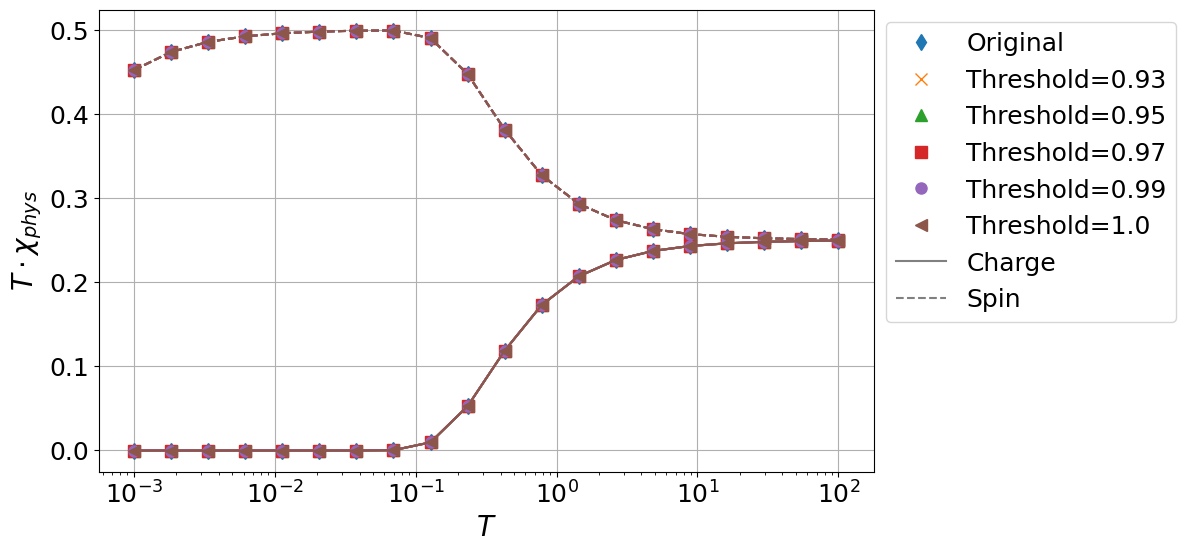

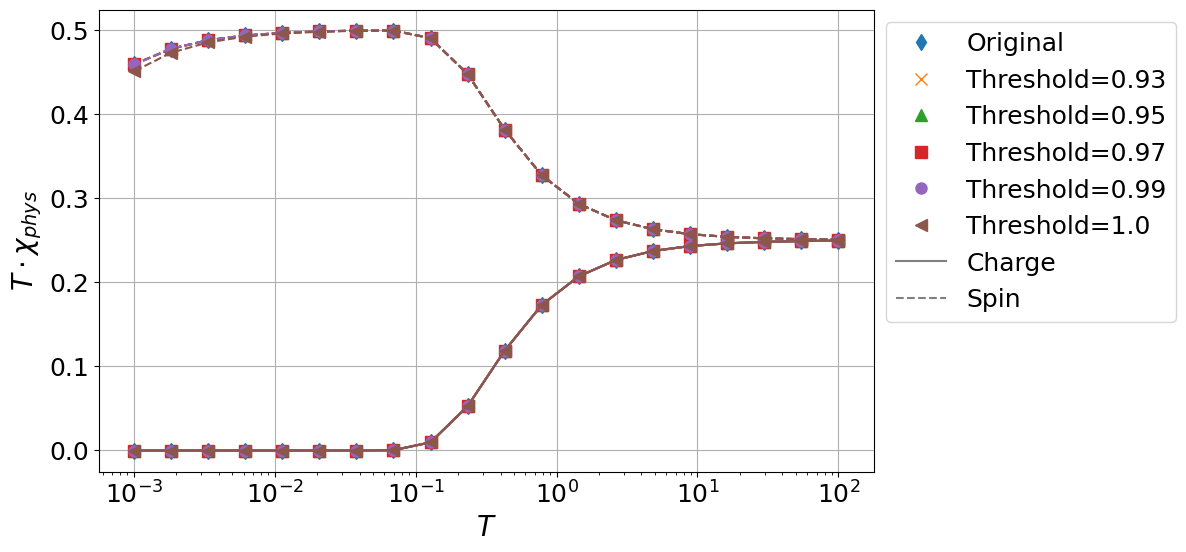

In [18]:
import itertools

# Define a list of markers
markers = ['d', 'x', '^', 's', 'o', '<', '>', 'p', '*', '+']

for niwf in niwfs:
    marker_cycler = itertools.cycle(markers)
    data = df.loc[df["niwf"] == niwf].copy()
    data.loc[:, '1/beta'] = 1 / data['beta']
    data.loc[:, 'T_phys_chi_charge'] = 1/data['beta'] * data['phys_chi_charge']
    data.loc[:, 'T_phys_chi_spin'] = 1/data['beta'] * data['phys_chi_spin']

    # Getting unique threshold values
    thresholds = data['threshold_quantile'].unique()

    # Create a new plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Looping over the unique threshold values
    for threshold in thresholds:
        temp_df = data[data['threshold_quantile'] == threshold]

        color = next(ax._get_lines.prop_cycler)['color']
        
        marker = next(marker_cycler)
        
        # Plotting T_phys_chi_charge
        plt.plot(temp_df['1/beta'], temp_df['T_phys_chi_charge'], color=color, marker=marker)
        
        # Plotting T_phys_chi_spin
        plt.plot(temp_df['1/beta'], temp_df['T_phys_chi_spin'], color=color, linestyle='--', marker=marker)

        if threshold == 0:
            plt.plot([], [], color=color, marker=marker, linestyle='none', label=f'Original')
        else:
            plt.plot([], [], color=color, marker=marker, linestyle='none', label=f'Threshold={threshold}')
        
    plt.plot([], [], color='grey', linestyle='-', label='Charge')
    plt.plot([], [], color='grey', linestyle='--', label='Spin')  
    
    # Set labels
    plt.xlabel(r'$T$')
    plt.ylabel(r'$T \cdot \chi_{phys}$')

    ax.set_xscale('log')
    
    ax.grid()

    # Add a legend
    plt.legend(bbox_to_anchor=(1, 1))

    # Show the plot
    plt.savefig(f'graphics/spin_charge_sep_{niwf}.pdf', bbox_inches='tight')

### Plot the physical susceptibility values and the differences between the original and compressed value

In [19]:
from matplotlib.ticker import ScalarFormatter


/var/folders/f3/5mwmxdln2t587p3x9czmpc3c0000gn/T/ipykernel_1736/3071542500.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/f3/5mwmxdln2t587p3x9czmpc3c0000gn/T/ipykernel_1736/3071542500.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


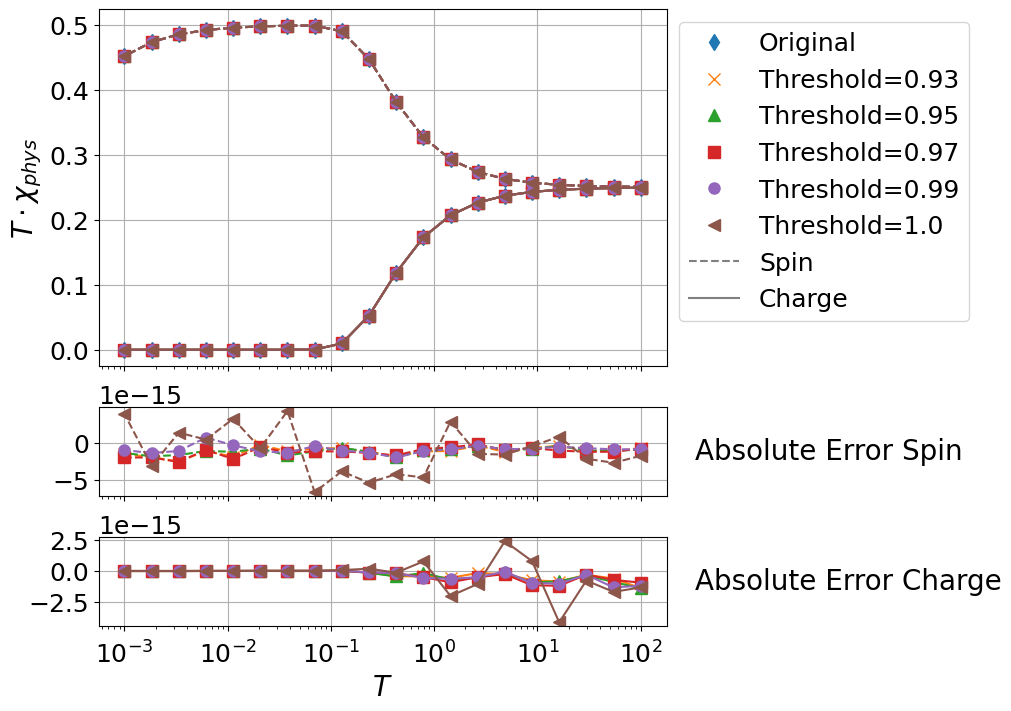

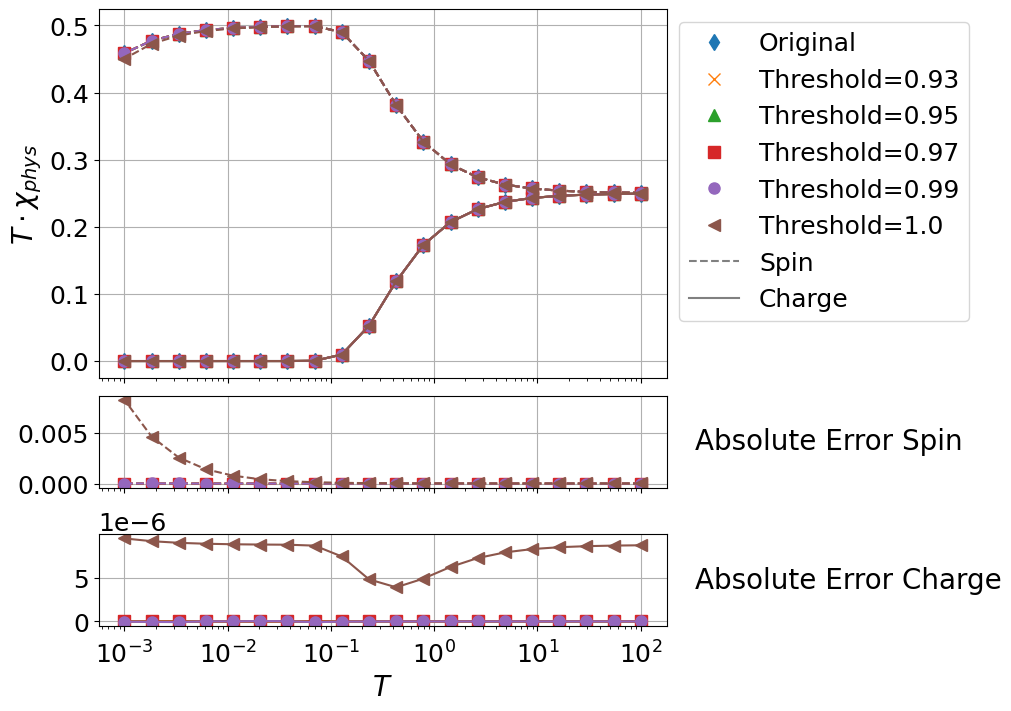

In [20]:
import matplotlib.pyplot as plt
import itertools

# Define a list of markers
markers = ['d', 'x', '^', 's', 'o', '<', '>', 'p', '*', '+']

for niwf in niwfs:
    marker_cycler = itertools.cycle(markers)
    data = df.loc[df["niwf"] == niwf].copy()
    data.loc[:, '1/beta'] = 1 / data['beta']
    data.loc[:, 'T_phys_chi_charge'] = 1/data['beta'] * data['phys_chi_charge']
    data.loc[:, 'T_phys_chi_spin'] = 1/data['beta'] * data['phys_chi_spin']

    # Getting unique threshold values
    thresholds = data['threshold_quantile'].unique()

    # Create a new figure with three subplots, the top one being larger
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 7), 
                                        gridspec_kw={'height_ratios': [4, 1, 1], 'hspace': 0.3}, 
                                        sharex=True, constrained_layout=True)

    # Extract the original data
    original_data = data[data['threshold_quantile'] == 0]
    orig_charge = original_data['T_phys_chi_charge'].values
    orig_spin = original_data['T_phys_chi_spin'].values

    # Looping over the unique threshold values
    for threshold in thresholds:
        temp_df = data[data['threshold_quantile'] == threshold]
        color = next(ax1._get_lines.prop_cycler)['color']
        marker = next(marker_cycler)

        # Plotting T_phys_chi_charge on ax1
        ax1.plot(temp_df['1/beta'], temp_df['T_phys_chi_charge'], color=color, marker=marker)

        # Plotting T_phys_chi_spin on ax1
        ax1.plot(temp_df['1/beta'], temp_df['T_phys_chi_spin'], color=color, linestyle='--', marker=marker)

        # Add legend entries
        if threshold == 0:
            ax1.plot([], [], color=color, marker=marker, linestyle='none', label=f'Original')
        else:
            ax1.plot([], [], color=color, marker=marker, linestyle='none', label=f'Threshold={threshold}')

            # Calculate differences and plot on ax2 and ax3
            diff_charge = orig_charge - temp_df['T_phys_chi_charge'].values
            diff_spin = orig_spin - temp_df['T_phys_chi_spin'].values

            ax3.plot(temp_df['1/beta'], diff_charge, color=color, marker=marker)
            ax2.plot(temp_df['1/beta'], diff_spin, color=color, linestyle='--', marker=marker)

    # Additional legend entries for spin/charge differentiation
    ax1.plot([], [], color='grey', linestyle='--', label='Spin') 
    ax1.plot([], [], color='grey', linestyle='-', label='Charge') 

    # Labels, scaling, and grids
    ax1.set_ylabel(r'$T \cdot \chi_{phys}$')
    ax3.set_ylabel('Charge Diff')
    ax2.set_ylabel('Spin Diff')
    ax3.set_xlabel(r'$T$')
    
    # Adjusting the x-axis for ax2 and ax3 to be on the right side
    ax3.set_ylabel("Absolute Error Charge", rotation=0, ha='left', va='center')
    ax3.yaxis.set_label_coords(1.05,0.5)
    ax3.yaxis.tick_left()

    ax2.set_ylabel("Absolute Error Spin", rotation=0, ha='left', va='center')
    ax2.yaxis.set_label_coords(1.05,0.5)
    ax2.yaxis.tick_left()
    
    dx = 0/72.; dy = -3/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    
    for ax in [ax2, ax3]:
        ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    # apply offset transform to all x ticklabels.
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)

    # Adjust space between subplots
    plt.tight_layout()
    
    for ax in [ax1, ax2, ax3]:
        ax.set_xscale('log')
        ax.grid()

    # Adding the legend to ax1
    ax1.legend(bbox_to_anchor=(1, 1))

    # Save the plot
    plt.savefig(f'graphics/spin_charge_sep_{niwf}.pdf', bbox_inches='tight')


# Preservation of Symmetries

In [21]:
betas = np.array([10,100,1000])
threshold_quantiles = np.array([0.9,.91,.92,0.93,.94,0.95,0.96,0.97,0.98,0.99])
niwf = 256
u = 1
levels = np.min([6, pywt.dwt_max_level(niwf, "haar")])

### Definition of helper functions for unfolding a matrix like in Figure 5.9

In [22]:
# generates the green triangle
def top_enclosed_matrix(matrix):
    # Check if the matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError('The input matrix should be square.')

    size = matrix.shape[0]

    # Initialize new_matrix as a complex-valued array
    new_matrix = np.zeros((size, size), dtype=complex)

    for i in range(size):
        for j in range(size):
            # Conditions for top area enclosed by main diagonal and antidiagonal
            if i + j < size and i <= j:
                new_matrix[i, j] = matrix[i, j]

    return new_matrix


In [23]:
# takes green and produces yellow & green
def mirror_anti_diagonal_conj(matrix):
    # Check that the input is a 2D square matrix
    assert matrix.ndim == 2, "The input matrix must be a 2D array"
    assert matrix.shape[0] == matrix.shape[1], "The input matrix must be square"

     # Create a copy of the original matrix
    mirrored_matrix = np.copy(matrix)
    
    # Get the size of the matrix
    n = matrix.shape[0]
    
    # Iterate through the matrix
    for i in range(n):
        for j in range(n-i-1):  # exclude the anti-diagonal by subtracting 1
            # Mirror the element and take the complex conjugate
            mirrored_matrix[n-1-j,n-1-i] = np.conj(matrix[i,j])
            
    return mirrored_matrix

In [24]:
# takes yellow and green and produces fully unfolded matrix
def mirror_upper_to_lower(matrix):
    # Check that the input is a 2D square matrix
    assert matrix.ndim == 2, "The input matrix must be a 2D array"
    assert matrix.shape[0] == matrix.shape[1], "The input matrix must be square"

    # Copy the input matrix to avoid altering the original one
    mirrored_matrix = matrix.copy()

    # Mirror the upper triangular matrix
    i_lower = np.tril_indices(matrix.shape[0], -1)
    mirrored_matrix[i_lower] = mirrored_matrix.T[i_lower]

    return mirrored_matrix

In [25]:
# function for full unfolding
def reconstruct_symmetries(X):
    return mirror_upper_to_lower(mirror_anti_diagonal_conj(top_enclosed_matrix(X)))

In [26]:
betas = np.array([10,100,1000])
threshold_quantiles = np.array([0.9,.91,.92,0.93,.94,0.95,0.96,0.97,0.98,0.99])
niwf = 256
u = 1
levels = np.min([6, pywt.dwt_max_level(niwf, "haar")])

The following code:
 1. computes the spin and charge susceptibility vertices
 2. compresses them
 3. strictly reconstructs the symmetries using the above shown helper functions
 4. computes the MSE between the compressed vertex and the compressed vertex where the symmetries are strictly reconstructed

In [27]:
data = pd.DataFrame(
                columns=['beta', 'threshold_quantile', 'mse_charge', 'mse_spin'])

for bidx, beta in enumerate(betas):
    chi_spin = al.chi_s(u, beta, u/2, niwf)
    chi_charge = al.chi_c(u, beta, u/2, niwf)
    
    for tidx, threshold_quantile in enumerate(threshold_quantiles):
        print(f"{threshold_quantile}")
            
        a = np.int32(niwf/(2**(level-1)))

        coeffs_c = pywt.wavedec2(chi_charge,'haar',level=level)
        coeff_c_arr,coeff_c_slices = pywt.coeffs_to_array(coeffs_c)

        coeffs_s = pywt.wavedec2(chi_spin,'haar',level=level)
        coeff_s_arr,coeff_s_slices = pywt.coeffs_to_array(coeffs_s)

        c_details = np.concatenate((coeff_c_arr[a:,:].flatten(), coeff_c_arr[:a,a:].flatten()))
        s_details = np.concatenate((coeff_s_arr[a:,:].flatten(), coeff_s_arr[:a,a:].flatten()))

        thresh_c = np.quantile(np.abs(c_details), threshold_quantile)
        thresh_s = np.quantile(np.abs(s_details), threshold_quantile)

        approx_c = np.copy(coeff_c_arr[:a,:a])
        coeff_c_arr_rec = (np.abs(coeff_c_arr[:,:]) > thresh_c) * coeff_c_arr[:,:]
        coeff_c_arr_rec[:a,:a] = np.copy(approx_c)

        approx_s = np.copy(coeff_s_arr[:a,:a])
        coeff_s_arr_rec = (np.abs(coeff_s_arr[:,:]) > thresh_s) * coeff_s_arr[:,:]
        coeff_s_arr_rec[:a,:a] = np.copy(approx_s)

        chi_charge_rec = pywt.waverec2(pywt.array_to_coeffs(coeff_c_arr_rec,coeff_c_slices,output_format='wavedec2'),'haar')
        chi_spin_rec   = pywt.waverec2(pywt.array_to_coeffs(coeff_s_arr_rec,coeff_s_slices,output_format='wavedec2'),'haar')

        chi_charge_rec_sym = reconstruct_symmetries(chi_charge_rec)
        chi_spin_rec_sym = reconstruct_symmetries(chi_spin_rec)
        
        mse_charge = np.mean(np.abs(chi_charge_rec - chi_charge_rec_sym))
        mse_spin = np.mean(np.abs(chi_spin_rec - chi_spin_rec_sym))

        data = data.append({'beta': beta, 
                            'threshold_quantile': threshold_quantile, 
                            'mse_spin': mse_spin,
                            'mse_charge': mse_charge
                           },
               ignore_index=True)

0.9


/Users/eminmoghadas/anaconda3/envs/wave_sus/lib/python3.8/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(


0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99


In [28]:
data

,beta,threshold_quantile,mse_charge,mse_spin
0,10.0,0.90,2.432574e-19,1.943428e-11
1,10.0,0.91,8.438071e-12,2.823498e-11
2,10.0,0.92,2.455277e-11,4.250180e-11
3,10.0,0.93,2.427920e-19,7.721867e-19
4,10.0,0.94,2.424596e-19,2.228417e-10
5,10.0,0.95,2.720219e-11,7.712122e-19
6,10.0,0.96,1.081419e-10,4.094784e-10
7,10.0,0.97,2.488795e-10,7.697710e-19
8,10.0,0.98,2.394587e-19,7.683258e-19
9,10.0,0.99,2.311535e-19,7.626847e-19


In [29]:
# rename to use df in the next cells
df = data

### Plot MSE for spin susceptibility

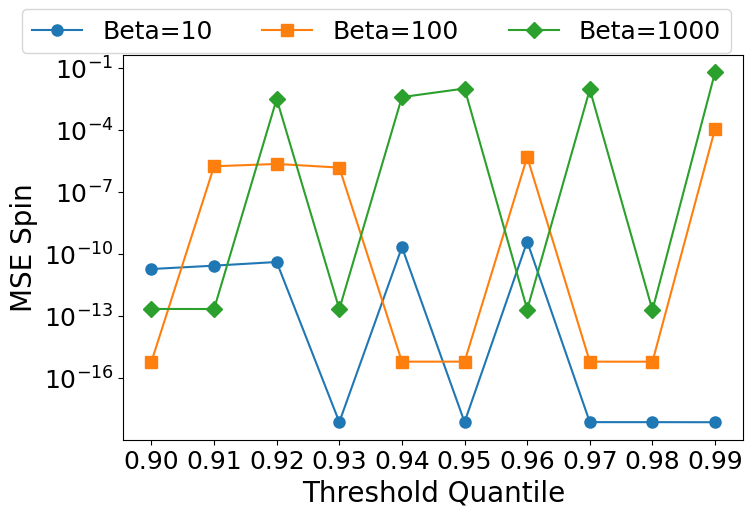

In [30]:
# Create a figure and an axis for the plot.
fig, ax = plt.subplots(figsize=(8,5))

# Define markers for different betas.
markers = ['o', 's', 'D'] # Circle, square, diamond.

# Plot a line for each beta value.
for beta, marker in zip(betas, markers):
    temp_df = df[df['beta'] == beta]
    ax.plot(temp_df['threshold_quantile'], temp_df['mse_spin'], marker=marker, label=f'Beta={beta}')

# Set the y-axis to be logarithmic.
ax.set_yscale('log')

# Adding labels and title.
plt.xlabel('Threshold Quantile')
plt.ylabel('MSE Spin')

ax.set_xticks(threshold_quantiles)


ax.legend(bbox_to_anchor=(1, 1.15), ncol=3)

# Show the plot.
plt.savefig('graphics/symmetry_spin.pdf', bbox_inches='tight')

### Plot MSE for charge susceptibility

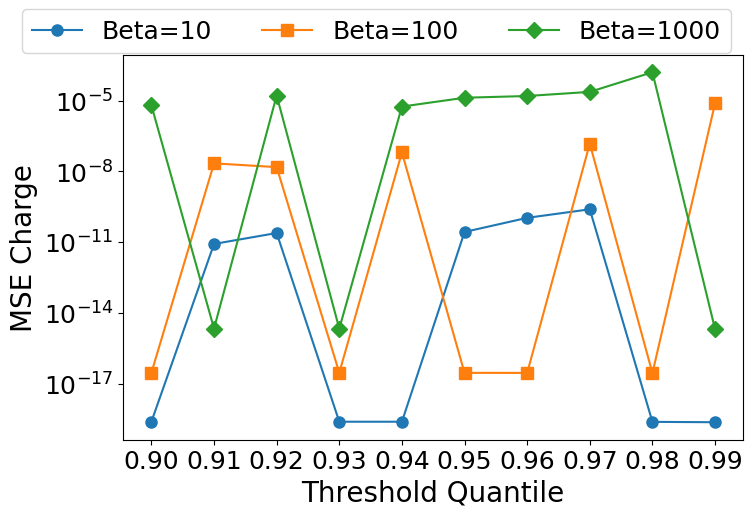

In [31]:
# Create a figure and an axis for the plot.
fig, ax = plt.subplots(figsize=(8,5))

# Define markers for different betas.
markers = ['o', 's', 'D'] # Circle, square, diamond.

# Plot a line for each beta value.
for beta, marker in zip(betas, markers):
    temp_df = df[df['beta'] == beta]
    ax.plot(temp_df['threshold_quantile'], temp_df['mse_charge'], marker=marker, label=f'Beta={beta}')

# Set the y-axis to be logarithmic.
ax.set_yscale('log')

# Adding labels and title.
plt.xlabel('Threshold Quantile')
plt.ylabel('MSE Charge')

ax.set_xticks(threshold_quantiles)

ax.legend(bbox_to_anchor=(1, 1.15), ncol=3)

# Show the plot.
plt.savefig('graphics/symmetry_charge.pdf', bbox_inches='tight')

# Eigenvalues and Eigenvectors

## Number of Negative Eigenvalues

In [32]:
niwf = 256
betas = 1 / np.linspace(0.1, 0.5, 21)
us = np.linspace(0.1, 1.9, 19)

In [33]:
# 2d array to store num of negative eigenvalues for given beta and U
num_evs_negative = np.zeros((betas.size, us.size))

for bidx, beta in enumerate(betas):
    for uidx, u in enumerate(us):
        chi_charge = al.chi_c(u, beta, u/2, niwf).real
        ws, vs = np.linalg.eigh(chi_charge)
        # from the eigenvalues ws, compute the number of evs that are negative
        num_evs_negative[bidx][uidx] = np.sum(ws < 0)

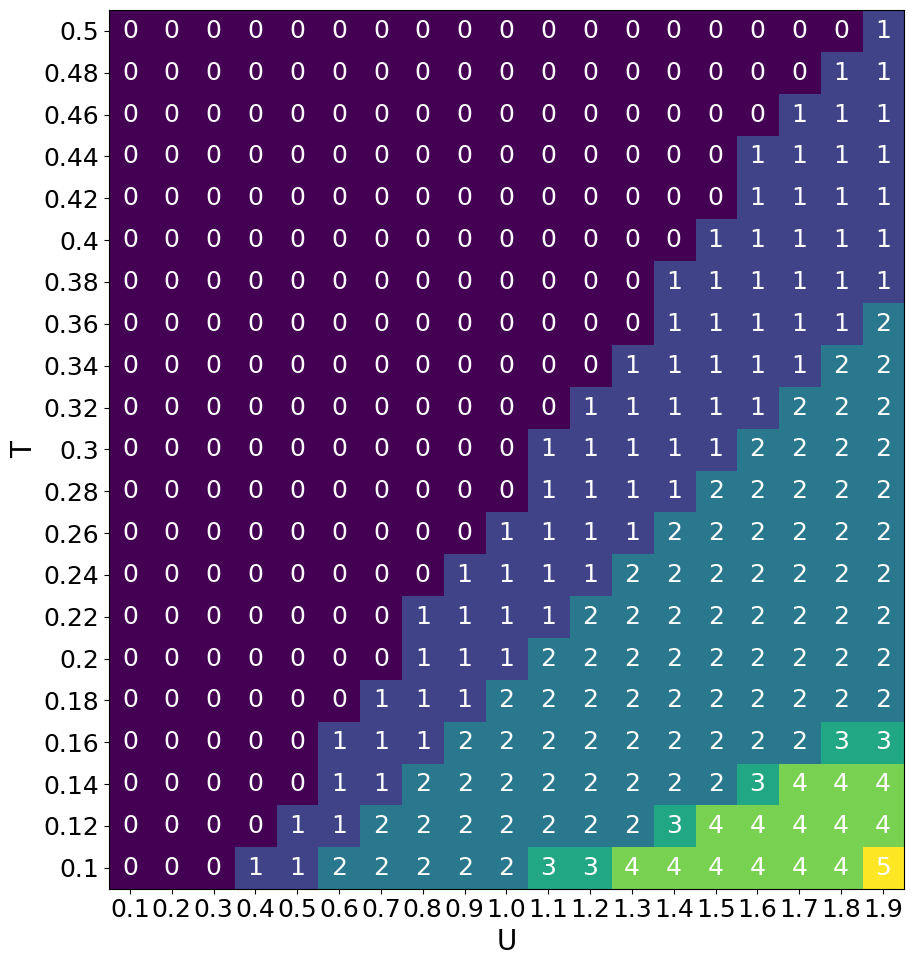

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(num_evs_negative, origin='lower')

ax.set_xticks(np.arange(len(us)))
ax.set_yticks(np.arange(len(betas)))

ax.set_xticklabels(np.round(us, 2))
ax.set_yticklabels(np.round(1/betas, 2))

ax.set_xlabel('U')
ax.set_ylabel('T')

for i in range(len(betas)):
    for j in range(len(us)):
        text = ax.text(j, i, num_evs_negative[i, j].astype(int),
                       ha="center", va="center", color="w")

fig.tight_layout()
plt.savefig('graphics/num_negative_evs.pdf', bbox_inches='tight')

## Find Zero of Eigenvalues efficiently using Bisection Method

In [35]:
def get_lambda_zero_position(ls, Us):
    # Check if the arrays have the same length
    if len(ls) != len(Us):
        raise ValueError("The input arrays must have the same length.")
    
    # Reverse the ls array
    ls_reversed = ls[::-1]
    
    # Find the index where ls first becomes greater than zero (looking from right to left)
    greater_than_zero_indices = np.where(ls_reversed > 0)[0]
    
    # If there is no such index, raise an exception
    if len(greater_than_zero_indices) == 0:
        raise ValueError("There is no element in 'ls' greater than zero.")
    
    # Get the index of the first occurrence
    first_greater_index = greater_than_zero_indices[0]
    
    # Convert the index for the reversed array to an index for the original array
    original_index = len(ls) - 1 - first_greater_index
    
    # Return the corresponding element from Us
    return Us[original_index]

In [36]:
# function that 
def compress(chi, level, q=0.3):
    a = np.int32(chi.shape[0]/(2**(level-1)))
    coeffs_c = pywt.wavedec2(chi_charge,'haar',level=level)
    coeff_c_arr,coeff_c_slices = pywt.coeffs_to_array(coeffs_c)

    c_details = np.concatenate((coeff_c_arr[a:,:].flatten(), coeff_c_arr[:a,a:].flatten()))

    thresh_c = np.quantile(np.abs(c_details), q)

    approx_c = np.copy(coeff_c_arr[:a,:a])
    coeff_c_arr_rec = (np.abs(coeff_c_arr[:,:]) > thresh_c) * coeff_c_arr[:,:]
    coeff_c_arr_rec[:a,:a] = np.copy(approx_c)

    chi_charge_rec = pywt.waverec2(pywt.array_to_coeffs(coeff_c_arr_rec,coeff_c_slices,output_format='wavedec2'),'haar')
    
    return chi_charge_rec

In [37]:
# function to compute the ratio of bytes needed to store compressed (sparse matrix format) vs uncompressed (standard 2d np array format) vertex 
def get_compression_ratio(chi, level, q=0.3):
    a = np.int32(chi.shape[0]/(2**(level-1)))
    coeffs_c = pywt.wavedec2(chi_charge,'haar',level=level)
    coeff_c_arr,coeff_c_slices = pywt.coeffs_to_array(coeffs_c)

    c_details = np.concatenate((coeff_c_arr[a:,:].flatten(), coeff_c_arr[:a,a:].flatten()))

    thresh_c = np.quantile(np.abs(c_details), q)

    approx_c = np.copy(coeff_c_arr[:a,:a])
    coeff_c_arr_rec = (np.abs(coeff_c_arr[:,:]) > thresh_c) * coeff_c_arr[:,:]
    coeff_c_arr_rec[:a,:a] = np.copy(approx_c)
    
    sp_rec_c = coo_matrix(coeff_c_arr_rec)
    return 1 - (sp_rec_c.data.nbytes + sp_rec_c.row.nbytes + sp_rec_c.col.nbytes)/coeff_c_arr_rec.nbytes

In [38]:
niwf = 256
beta = 1/0.3
u=1

In [39]:
from IPython.display import clear_output
start_value = 0.1
end_value = 2
num_points = 2
precision = 1e-7  # desired precision
level = 6
threshold_quantiles = np.array([0.91, 0.93, 0.95, 0.97, 0.99])

iteration_time = 1
iterations_needed = np.ceil(np.log2((end_value - start_value)/precision))
iteration = 0

data = pd.DataFrame(
    columns=['threshold_quantile', 'zero_original', 'zero_compressed', 'precision', 'compression_ratio', 'ssim'])

for threshold_quantile in threshold_quantiles:
    for cidx, compr in enumerate([True, False]):
        while (end_value - start_value) > precision:
            # Generate linspace
            us = np.linspace(start_value, end_value, (num_points + 1))

            l1s = np.zeros(us.size)
            l1s[:-1] = -1
            for uidx, u in enumerate(us[:-1]):
                chi_charge = al.chi_c(u, beta, u/2, niwf).real
                if compr:
                    chi_charge_rec = compress(chi_charge, level, threshold_quantile)
                    assert not np.array_equal(chi_charge_rec, chi_charge)
                    #print(np.mean(np.square(chi_charge_rec - chi_charge)))
                    ws = np.sort(np.linalg.eigvals(chi_charge_rec))
                else:
                    ws = np.sort(np.linalg.eigvals(chi_charge))
                l1s[uidx] = np.min(ws)

            zero_pos = get_lambda_zero_position(l1s, us)

            # Update start and end values, making the range a fraction of the previous range
            range_length = (end_value - start_value) / num_points
            start_value = zero_pos
            end_value = min(end_value, start_value + range_length)
        if not compr:
            zero_original = start_value + (end_value - start_value) / 2
    zero_compressed = start_value + (end_value - start_value) / 2
    ssim_charge = ssim(chi_charge, chi_charge_rec, multichannel=False)
    compr_ration = get_compression_ratio(chi_charge, level, threshold_quantile)
    
    print(zero_original)

    data = data.append({'threshold_quantile': threshold_quantile,
                        'zero_original': zero_original,
                        'zero_compressed': zero_compressed,
                        'precision': precision,
                        'compression_ratio': compr_ration,
                        'ssim': ssim_charge
                       },
           ignore_index=True)

1.0882796034216877
1.0882796034216877
1.0882796034216877
1.0882796034216877
1.0882796034216877


/var/folders/f3/5mwmxdln2t587p3x9czmpc3c0000gn/T/ipykernel_1736/3407357507.py:44: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_charge = ssim(chi_charge, chi_charge_rec, multichannel=False)


In [40]:
data

,threshold_quantile,zero_original,zero_compressed,precision,compression_ratio,ssim
0,0.91,1.08828,1.08828,1.000000e-07,0.818222,1.0
1,0.93,1.08828,1.08828,1.000000e-07,0.858185,1.0
2,0.95,1.08828,1.08828,1.000000e-07,0.898148,1.0
3,0.97,1.08828,1.08828,1.000000e-07,0.938110,1.0
4,0.99,1.08828,1.08828,1.000000e-07,0.978073,1.0


## Change of Eigenvalues

In [41]:
def compress(chi, level, q=0.3):
    a = np.int32(chi.shape[0]/(2**(level-1)))
    coeffs_c = pywt.wavedec2(chi_charge,'haar',level=level)
    coeff_c_arr,coeff_c_slices = pywt.coeffs_to_array(coeffs_c)

    c_details = np.concatenate((coeff_c_arr[a:,:].flatten(), coeff_c_arr[:a,a:].flatten()))

    thresh_c = np.quantile(np.abs(c_details), q)

    approx_c = np.copy(coeff_c_arr[:a,:a])
    coeff_c_arr_rec = (np.abs(coeff_c_arr[:,:]) > thresh_c) * coeff_c_arr[:,:]
    coeff_c_arr_rec[:a,:a] = np.copy(approx_c)

    chi_charge_rec = pywt.waverec2(pywt.array_to_coeffs(coeff_c_arr_rec,coeff_c_slices,output_format='wavedec2'),'haar')
    
    return chi_charge_rec

In [42]:
beta = 1 / 0.3
niwf = 1024
u = 1.0882796034216877
threshold_quantiles = np.array([0.6,0.7,0.8,0.9,0.95,0.99])
chi_charge = al.chi_c(u, beta, u/2, niwf).real

data = pd.DataFrame(
                columns=['threshold', 'v', 'v_rec'])

ws, vs = np.linalg.eig(chi_charge)
v = vs[:,np.argmin(ws)]

for threshold in threshold_quantiles:
    chi_charge_rec = compress(chi_charge, 6, threshold)
    ws_rec, vs_rec = np.linalg.eig(chi_charge_rec)
    print(np.min(ws_rec))
    v_rec = vs_rec[:,np.argmin(ws_rec)]
    
    data = data.append({'threshold': threshold, 
                            'v': v, 
                            'v_rec': v_rec
                           },
               ignore_index=True)

5.864987212562167e-08
5.864987215334041e-08
5.8649872125518634e-08
5.8649872097780184e-08
5.8649872125537295e-08
5.864987204232986e-08


In [43]:
data

,threshold,v,v_rec
0,0.60,"[1.7838474332616306e-13, 2.0219854427931441e-1...","[-1.810290327429784e-13, -1.9984931361621146e-..."
1,0.70,"[1.7838474332616306e-13, 2.0219854427931441e-1...","[1.9132674522132532e-13, 2.067744393543976e-13..."
2,0.80,"[1.7838474332616306e-13, 2.0219854427931441e-1...","[-1.7881745672251484e-13, -2.0200121092292883e..."
3,0.90,"[1.7838474332616306e-13, 2.0219854427931441e-1...","[1.885538290944927e-13, 2.1001422830360146e-13..."
4,0.95,"[1.7838474332616306e-13, 2.0219854427931441e-1...","[-1.7603557519635734e-13, -2.0613548758822235e..."
5,0.99,"[1.7838474332616306e-13, 2.0219854427931441e-1...","[-1.898329307268891e-13, -2.0729403886313723e-..."


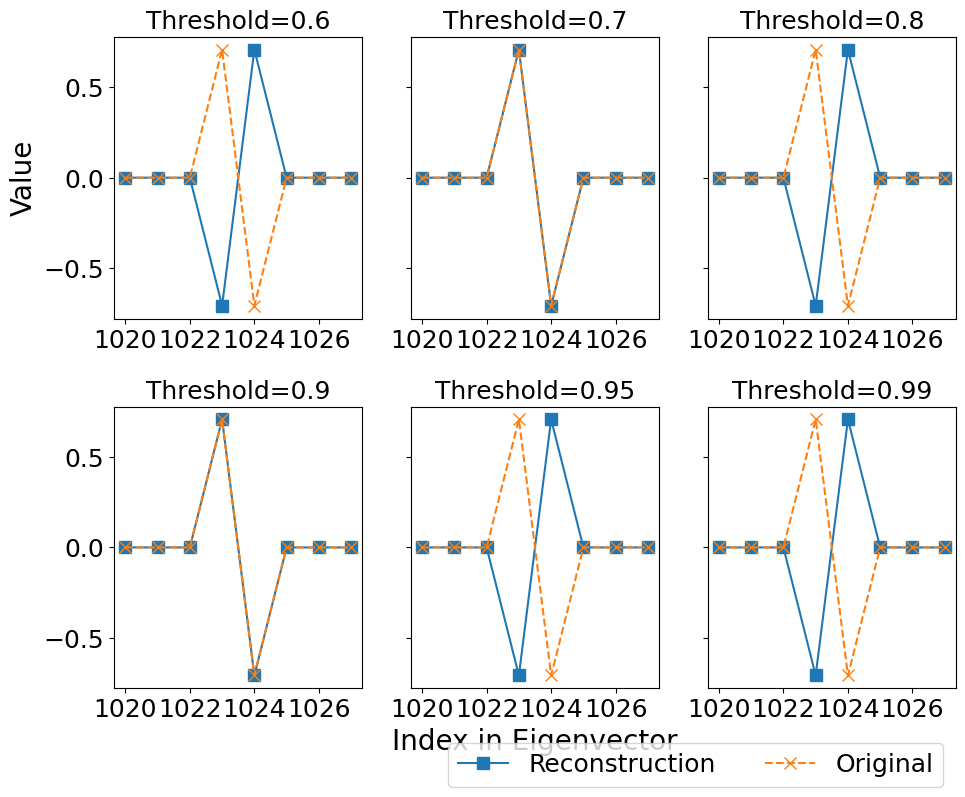

In [44]:
fig, axs = plt.subplots(2, len(data)//2, figsize=(10, 8), sharey=True)

axs = axs.flatten()
x_values = np.arange(1020, 1028)

# Loop over each row in the DataFrame
for i, row in data.iterrows():
    axs[i].plot(x_values, row['v_rec'][1020:1028], label=f"Reconstruction", marker='s')
    axs[i].plot(x_values, data.iloc[0]['v'][1020:1028], label='Original', linestyle='--', marker='x')
    axs[i].set_title(f"Threshold={row['threshold']}")
    axs[i].xaxis.set_ticks(x_values[x_values % 2 == 0])
    #axs[i].set_xlabel('Index')

# Set y-label on the first subplot
axs[0].set_ylabel('Value')
axs[len(data)-2].set_xlabel('Index in Eigenvector')

# Adjust layout for readability
plt.tight_layout()

# Optional: Add legend to the last plot
axs[-1].legend(bbox_to_anchor=(1, -0.15), ncol=2)

# Show the plot
plt.savefig('graphics/eigenvectors.pdf', bbox_inches='tight')


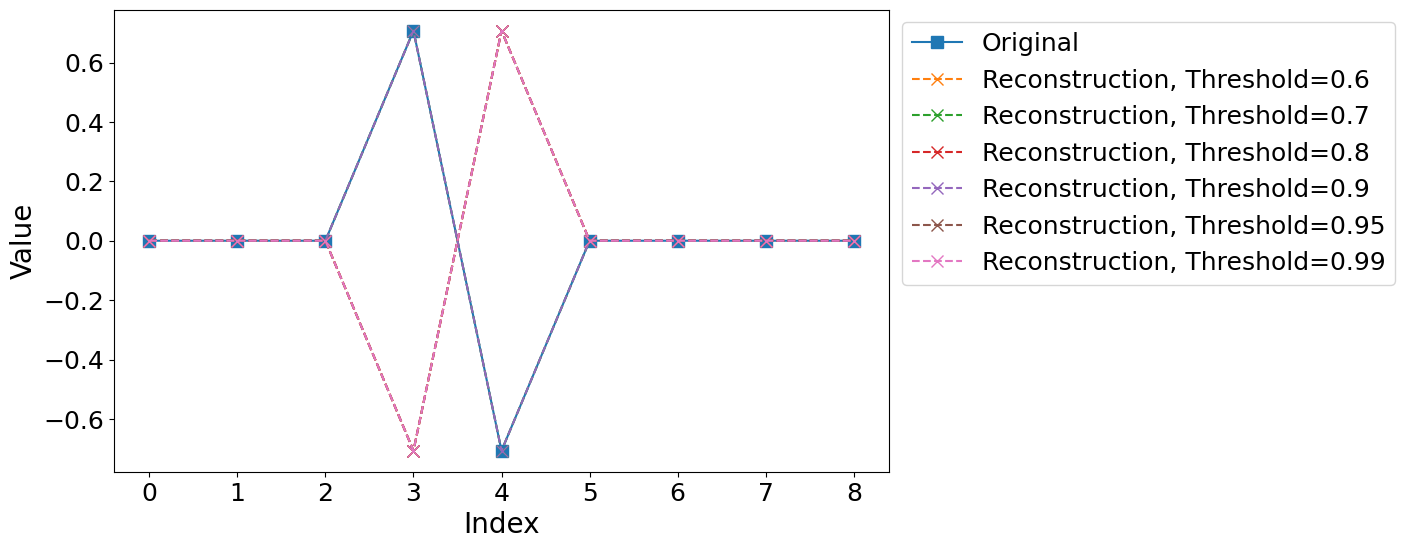

In [45]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Add 'vs' as a baseline
ax.plot(data.iloc[0]['v'][1020:1029], label='Original', marker='s')

# Loop over each row in the DataFrame
for i, row in data.iterrows():
    ax.plot(row['v_rec'][1020:1029], label=f"Reconstruction, Threshold={row['threshold']}", linestyle='--', marker='x')

# Customize the plot
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.legend(bbox_to_anchor=(1, 1))


# Show the plot
plt.show()

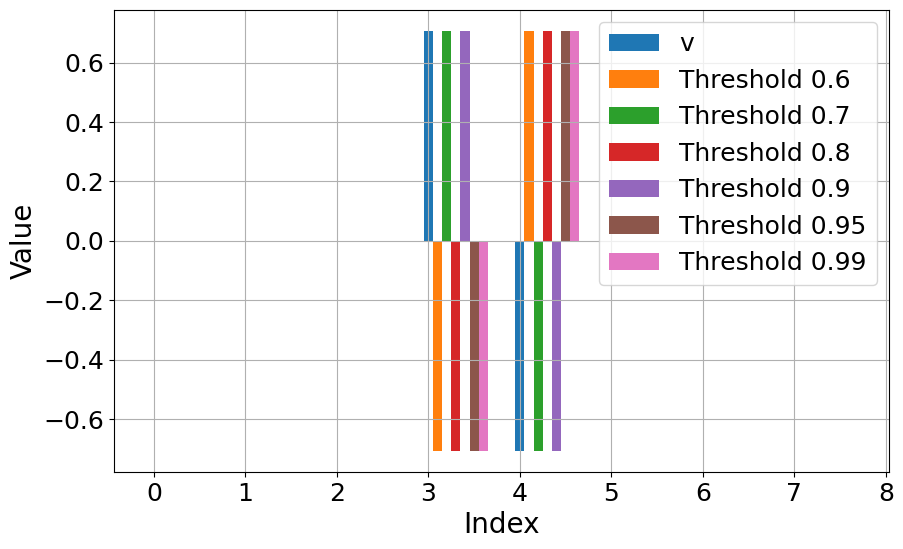

In [46]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Bar width
bar_width = 0.1

# Add 'v' as a baseline
ax.bar(np.arange(8), data.iloc[0]['v'][1020:1028], width=bar_width, label='v')

# Loop over each row in the DataFrame
for i, row in data.iterrows():
    # Offset x coordinates for each bar to avoid overlap
    x_coordinates = np.arange(8) + (i + 1) * bar_width
    ax.bar(x_coordinates, row['v_rec'][1020:1028], width=bar_width, label=f"Threshold {row['threshold']}")

# Customize the plot
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.legend()
ax.grid()

plt.savefig('graphics/eigenvectors.pdf', bbox_inches='tight')

# Vertex Size and Wavelet Basis

32.0
57.0
82.0
107.0
132.0
157.0
182.0
207.0
232.0
257.0
282.0
307.0
332.0
357.0
382.0
407.0
432.0
457.0
482.0
507.0
32.0
57.0
82.0
107.0
132.0
157.0
182.0
207.0
232.0
257.0
282.0
307.0
332.0
357.0
382.0
407.0
432.0
457.0
482.0
507.0
32.0
57.0
82.0
107.0
132.0
157.0
182.0
207.0
232.0
257.0
282.0
307.0
332.0
357.0
382.0
407.0
432.0
457.0
482.0
507.0
32.0
57.0
82.0
107.0
132.0
157.0
182.0
207.0
232.0
257.0
282.0
307.0
332.0
357.0
382.0
407.0
432.0
457.0
482.0
507.0
32.0
57.0
82.0
107.0
132.0
157.0
182.0
207.0
232.0
257.0
282.0
307.0
332.0
357.0
382.0
407.0
432.0
457.0
482.0
507.0
32.0
57.0
82.0
107.0
132.0
157.0
182.0
207.0
232.0
257.0
282.0
307.0
332.0
357.0
382.0
407.0
432.0
457.0
482.0
507.0


<Figure size 640x480 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

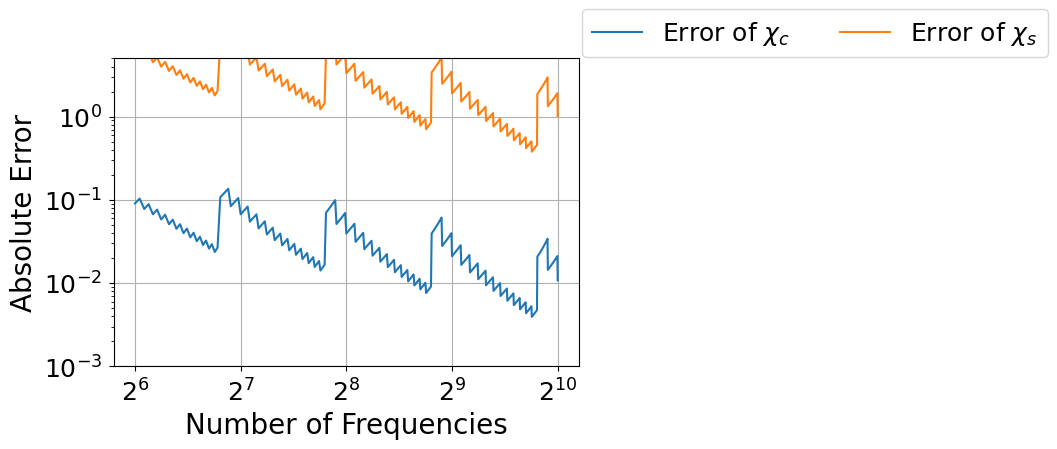

In [57]:
start=32
niwfs = np.linspace(start, 512, 512-start+1)
u=1
beta = 100
compr_quantile = 1

waveletbases = ["rbio4.4", "coif2", "bior4.4", "haar", "sym4", "db4"]

for waveletbase in waveletbases:

    diffs_charge = np.zeros(512-start+1)
    diffs_spin = np.zeros(512-start+1)
    maxlev = np.zeros(512-start+1)

    for nidx, niwf in enumerate(niwfs):

        if nidx % 25 == 0:
            print(f"{niwf}")

        chi_spin = al.chi_s(u, beta, u/2, niwf).real
        chi_charge = al.chi_c(u, beta, u/2, niwf).real

        level = pywt.dwtn_max_level((niwf,niwf), waveletbase)

        a = np.int32(niwf/(2**(level-1)))

        coeffs_c = pywt.wavedec2(chi_charge,waveletbase,level=level)
        coeff_c_arr, coeff_c_slices = pywt.coeffs_to_array(coeffs_c)

        coeffs_s = pywt.wavedec2(chi_spin,waveletbase,level=level)
        coeff_s_arr, coeff_s_slices = pywt.coeffs_to_array(coeffs_s)

        c_details = np.concatenate((coeff_c_arr[a:,:].flatten(), coeff_c_arr[:a,a:].flatten()))
        s_details = np.concatenate((coeff_s_arr[a:,:].flatten(), coeff_s_arr[:a,a:].flatten()))

        thresh_c = np.quantile(np.abs(c_details), compr_quantile)
        thresh_s = np.quantile(np.abs(s_details), compr_quantile)

        approx_c = np.copy(coeff_c_arr[:a,:a]) # save the approximation part
        coeff_c_arr_rec = (np.abs(coeff_c_arr[:,:]) > thresh_c) * coeff_c_arr[:,:] # tresholding all the entries (approximation part + details parts)
        coeff_c_arr_rec[:a,:a] = np.copy(approx_c) # reintroduce the approximation part

        approx_s = np.copy(coeff_s_arr[:a,:a])
        coeff_s_arr_rec = (np.abs(coeff_s_arr[:,:]) > thresh_s) * coeff_s_arr[:,:]
        coeff_s_arr_rec[:a,:a] = np.copy(approx_s)

        sp_rec_s = coo_matrix(coeff_s_arr_rec)
        sp_rec_c = coo_matrix(coeff_s_arr_rec)

        chi_charge_rec = pywt.waverec2(pywt.array_to_coeffs(coeff_c_arr_rec, coeff_c_slices, "wavedec2"),waveletbase)
        chi_spin_rec   = pywt.waverec2(pywt.array_to_coeffs(coeff_s_arr_rec, coeff_s_slices, "wavedec2"),waveletbase)

        sus_spin = 1/beta**2 * np.sum(chi_spin)
        sus_charge = 1/beta**2 * np.sum(chi_charge)

        sus_spin_rec = 1/beta**2 * np.sum(chi_spin_rec)
        sus_charge_rec = 1/beta**2 * np.sum(chi_charge_rec)

        diffs_charge[nidx] = np.abs((sus_charge_rec - sus_charge)) #/ sus_charge)
        diffs_spin[nidx] = np.abs((sus_spin_rec - sus_spin)) #/ sus_spin)
        maxlev[nidx] = level
    
    plt.clf()
    fig, ax = plt.subplots(figsize=(6,4))

    ax.set_xlabel(r"Number of Frequencies")
    ax.set_ylabel("Absolute Error")
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.plot(2*niwfs, diffs_charge, label=r"Error of $\chi_c$")
    ax.plot(2*niwfs, diffs_spin, label=r"Error of $\chi_s$")
    ax.grid()
    if waveletbase != "haar":
        ax.set_ylim([10**-3, 5*10**0])
    ax.legend(bbox_to_anchor=(0.98, 1.2), ncol=2)
    ax.set_xticks(np.array([2**i for i in range(6,11)]))
    ax.tick_params(direction='out', pad=5)
    plt.savefig(f"graphics/niwf_sizes_{waveletbase}_abs.pdf", bbox_inches="tight")

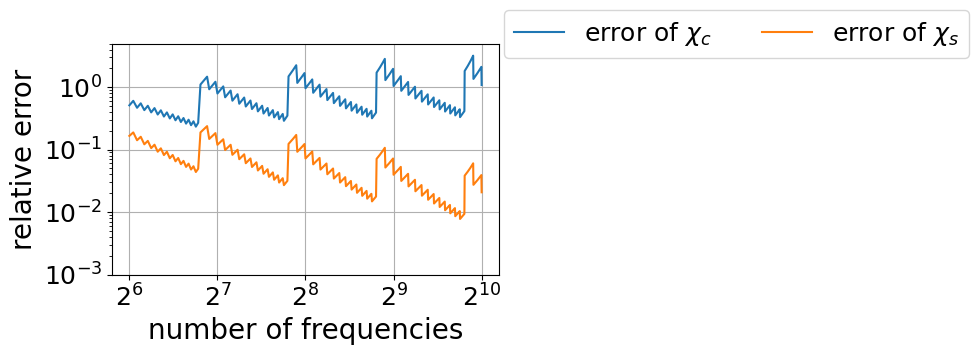

In [43]:
fig, ax = plt.subplots(figsize=(5,3))

ax.set_xlabel(r"number of frequencies")
ax.set_ylabel("relative error")
ax.set_yscale('log')
ax.set_xscale('log', base=2)
ax.plot(2*niwfs, diffs_charge, label=r"error of $\chi_c$")
ax.plot(2*niwfs, diffs_spin, label=r"error of $\chi_s$")
ax.grid()
ax.legend(bbox_to_anchor=(0.98, 1.2), ncol=2)
ax.set_ylim([10**-3, 5*10**0])
ax.set_xticks(np.array([2*2**i for i in range(5,10)]))
plt.savefig(f"graphics/niwf_sizes_{waveletbase}.pdf")

# Self Energy

## Applying transform directly on Self energy vector

Note: not included in the thesis

In [48]:
niwf = 32
U, betas = 1, np.array([10,100,1000])
mu = U/2
threshold_quantiles = np.array([0.6, 0.7, 0.8, 0.9, 0.95])
waveletbase = "haar"

data = pd.DataFrame(columns=['beta', 'threshold_quantile', 'v', 'selfenergy', 'selfenergy_rec'])

for beta in betas:
    atom = al_se.atom(U,beta,mu,Niwf=niwf)
    v = np.imag(atom.iw())

    # exact selfenergy
    selfenergy = atom.sigma()

    coeffs_se = pywt.wavedec(selfenergy, waveletbase, level=pywt.dwt_max_level(niwf, waveletbase))
    coeff_se_arr, coeff_se_slices = pywt.coeffs_to_array(coeffs_se)

    for threshold in threshold_quantiles:
        a = coeffs_se[0].size
        se_details = coeff_se_arr[a:]

        thresh_se = np.quantile(np.abs(se_details), threshold)

        approx_se = np.copy(coeff_se_arr[:a])
        coeff_se_arr_rec = (np.abs(coeff_se_arr) > thresh_se) * coeff_se_arr
        coeff_se_arr_rec[:a] = np.copy(approx_se)

        selfenergy_rec = pywt.waverec(pywt.array_to_coeffs(coeff_se_arr_rec,coeff_se_slices,output_format='wavedec'),waveletbase)
        data = data.append({'beta': beta,
                        'threshold_quantile': threshold,
                        'v': v,
                        'selfenergy': selfenergy,
                        'selfenergy_rec': selfenergy_rec
                       },
           ignore_index=True)

In [49]:
data

,beta,threshold_quantile,v,selfenergy,selfenergy_rec
0,10,0.60,"[-19.792033717615695, -19.16371518689774, -18....","[(0.49999999999999983+0.012631344689832957j), ...","[(0.5000000000000001+0.014306559170294894j), (..."
1,10,0.70,"[-19.792033717615695, -19.16371518689774, -18....","[(0.49999999999999983+0.012631344689832957j), ...","[(0.5000000000000001+0.014306559170294894j), (..."
2,10,0.80,"[-19.792033717615695, -19.16371518689774, -18....","[(0.49999999999999983+0.012631344689832957j), ...","[(0.5000000000000001+0.017234123210640006j), (..."
3,10,0.90,"[-19.792033717615695, -19.16371518689774, -18....","[(0.49999999999999983+0.012631344689832957j), ...","[(0.5000000000000001+0.0675076407623808j), (0...."
4,10,0.95,"[-19.792033717615695, -19.16371518689774, -18....","[(0.49999999999999983+0.012631344689832957j), ...","[(0.5000000000000001+0.0675076407623808j), (0...."
5,100,0.60,"[-1.9792033717615698, -1.916371518689774, -1.8...","[(0.5+0.1263134468983298j), (0.5+0.13045487138...","[(0.5000000000000001+0.14306559170294492j), (0..."
6,100,0.70,"[-1.9792033717615698, -1.916371518689774, -1.8...","[(0.5+0.1263134468983298j), (0.5+0.13045487138...","[(0.5000000000000001+0.14306559170294492j), (0..."
7,100,0.80,"[-1.9792033717615698, -1.916371518689774, -1.8...","[(0.5+0.1263134468983298j), (0.5+0.13045487138...","[(0.5000000000000001+0.17234123210639735j), (0..."
8,100,0.90,"[-1.9792033717615698, -1.916371518689774, -1.8...","[(0.5+0.1263134468983298j), (0.5+0.13045487138...","[(0.5000000000000001+0.6750764076238077j), (0...."
9,100,0.95,"[-1.9792033717615698, -1.916371518689774, -1.8...","[(0.5+0.1263134468983298j), (0.5+0.13045487138...","[(0.5000000000000001+0.6750764076238077j), (0...."


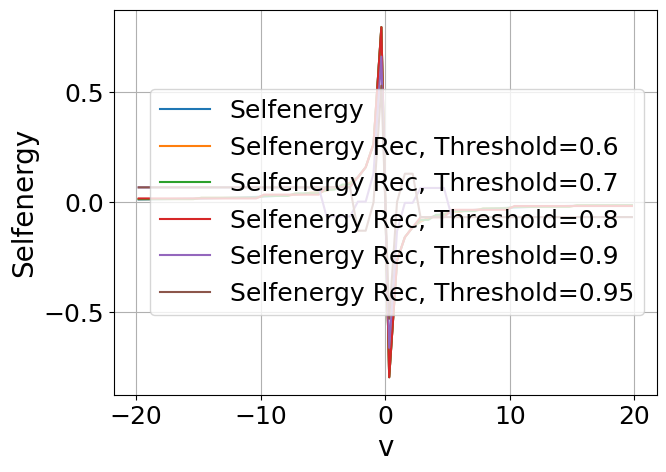

In [50]:
beta_value = 10

# Creating a temporary DataFrame where beta equals to the given beta_value
temp_df = data[data['beta'] == beta_value]

# Getting unique threshold values
thresholds = temp_df['threshold_quantile'].unique()

# Create a new plot
plt.figure(figsize=(7,5))

# Plot the selfenergy, as it's the same for all thresholds we only need to plot it once
v_values = temp_df['v'].iloc[0]  # Assuming v is same across all thresholds
selfenergy_values = temp_df['selfenergy'].iloc[0].imag  # Plotting only the real part, change as needed
plt.plot(v_values, selfenergy_values, label='Selfenergy')

# Looping over the unique threshold values
for threshold in thresholds:
    single_threshold_df = temp_df[temp_df['threshold_quantile'] == threshold]
    
    # Getting selfenergy_rec values
    selfenergy_rec_values = single_threshold_df['selfenergy_rec'].iloc[0].imag  # Plotting only the real part, change as needed
    
    # Plotting selfenergy_rec
    plt.plot(v_values, selfenergy_rec_values, label=f'Selfenergy Rec, Threshold={threshold}')

# Set labels
plt.xlabel('v')
plt.ylabel('Selfenergy')

plt.grid()

# Add a legend
plt.legend()

plt.savefig('graphics/selfenergy.pdf', bbox_inches='tight')

## Using transform on fully connected Greens function

In [41]:
niwf = 50
U, betas = 1, np.array([10]) #,100,1000])
mu = U/2
threshold_quantiles = np.array([0.9, 0.99, 1])

data = pd.DataFrame(columns=['beta', 'threshold_quantile', 'v', 'selfenergy', 'selfenergy_rec'])

for waveletbase in ['haar']: #, 'bior4.4']:
    for beta in betas:
        atom = al_se.atom(U,beta,mu,Niwf=niwf)

        #g = atom.g()
        # for the Green's function more Matsubara 
        # frequencies are needed
        at_more_fq = al_se.atom(U,beta,mu,Niwf=niwf)
        g = at_more_fq.g()


        # bosonic Matsubara frequencies
        Niwb = atom.Niwf
        iO = np.arange(-Niwb,Niwb+1)

        v = np.imag(atom.iw())

        # exact selfenergy
        selfenergy = atom.sigma()

        # g2_ud : iv, iv', iO
        g2_ud = np.moveaxis(np.array([atom.g2ud(omega=io) for io in iO]), 0 , -1)
        g2_ud = np.sum(g2_ud, axis=2)
        
        selfenergy = Sigma(g,g2_ud,beta,U)

        coeffs_g2 = pywt.wavedec2(g2_ud, waveletbase, level=pywt.dwtn_max_level(g2_ud.shape, waveletbase))
        print(pywt.dwtn_max_level(g2_ud.shape, waveletbase))
        coeff_g2_arr, coeff_g2_slices = pywt.coeffs_to_array(coeffs_g2)

        for threshold in threshold_quantiles:
            a = coeffs_g2[0].shape
            print(a)
            g2_details = coeff_g2_arr[a[0]:,a[1]:]

            thresh_g2 = np.quantile(np.abs(g2_details), threshold)

            approx_g2 = np.copy(coeff_g2_arr[:a[0],:a[1]])
            coeff_g2_arr_rec = coeff_g2_arr
            coeff_g2_arr_rec = (np.abs(coeff_g2_arr) > thresh_g2) * coeff_g2_arr
            coeff_g2_arr_rec[:a[0],:a[1]] = np.copy(approx_g2)

            g2_ud_rec = pywt.waverec2(pywt.array_to_coeffs(coeff_g2_arr_rec,coeff_g2_slices,output_format='wavedec2'),waveletbase)

            selfenergy_rec = Sigma(g,g2_ud_rec,beta,U)

            data = data.append({'wavelet': waveletbase,
                            'beta': beta,
                            'threshold_quantile': threshold,
                            'v': v,
                            'selfenergy': selfenergy,
                            'selfenergy_rec': selfenergy_rec
                           },
               ignore_index=True)

6
(2, 2)
(2, 2)
(2, 2)


8


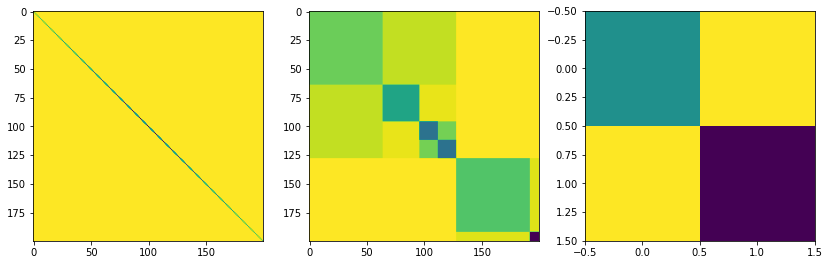

In [60]:
niwf = 100
U, beta = 1, 1000
mu = U/2
threshold = 1.
waveletbase = "haar"

atom = al_se.atom(U,beta,mu,Niwf=niwf)

# GF
g = atom.g()

# bosonic Matsubara frequencies
Niwb = atom.Niwf
iO = np.arange(-Niwb,Niwb+1)

v = np.imag(atom.iw())

# exact selfenergy
selfenergy = atom.sigma()

# g2_ud : iv, iv', iO
g2_ud = np.moveaxis(np.array([atom.g2ud(omega=io) for io in iO]), 0 , -1)
#g2_ud = np.sum(g2_ud, axis=2)

# DWT
coeffs_g2 = pywt.wavedecn(g2_ud, waveletbase, level=pywt.dwtn_max_level(g2_ud.shape, waveletbase))
coeff_g2_arr, coeff_g2_slices = pywt.coeffs_to_array(coeffs_g2)

a = coeffs_g2[0].shape
g2_details = coeff_g2_arr[a[0]:,a[1]:,a[2]:]

thresh_g2 = np.quantile(np.abs(g2_details), threshold)

approx_g2 = np.copy(coeff_g2_arr[:a[0],:a[1],:a[2]])
coeff_g2_arr_rec = coeff_g2_arr
coeff_g2_arr_rec = (np.abs(coeff_g2_arr) >= thresh_g2) * coeff_g2_arr
print(np.sum(np.abs(coeff_g2_arr) >= thresh_g2))
coeff_g2_arr_rec[:a[0],:a[1],:a[2]] = np.copy(approx_g2)

g2_ud_rec = pywt.waverecn(pywt.array_to_coeffs(coeff_g2_arr_rec,coeff_g2_slices,output_format='wavedecn'),waveletbase)

fig, axs = plt.subplots(1,3, figsize=(14,6))
axs[0].imshow(np.sum(g2_ud, axis=2).real)
axs[1].imshow(np.sum(g2_ud_rec, axis=2).real)
axs[2].imshow(np.sum(approx_g2, axis=2).real)

### Batch plot generation

In [42]:
for beta_value in [10]: #,100,1000]:
    for waveletbase in ['haar']: #,'bior4.4']:

        # Creating a temporary DataFrame where beta equals to the given beta_value and wavelet is the given waveletbase
        temp_df = data[(data['beta'] == beta_value) & (data['wavelet'] == waveletbase)]

        # Getting unique threshold values
        thresholds = temp_df['threshold_quantile'].unique()

        # Create a new plot
        plt.figure(figsize=(8,5.5))

        # Plot the selfenergy, as it's the same for all thresholds we only need to plot it once
        v_values = temp_df['v'].iloc[0]  # Assuming v is same across all thresholds
        selfenergy_values = temp_df['selfenergy'].iloc[0].imag  # Plotting only the real part, change as needed
        plt.plot(v_values, selfenergy_values, label='Uncompressed Self-energy', linewidth=3)

        # Looping over the unique threshold values
        for threshold in thresholds:
            single_threshold_df = temp_df[temp_df['threshold_quantile'] == threshold]

            # Getting selfenergy_rec values
            selfenergy_rec_values = single_threshold_df['selfenergy_rec'].iloc[0].imag

            # Plotting selfenergy_rec
            plt.plot(v_values, selfenergy_rec_values, label=f'Reconstruction, T={threshold:.2f}')

        # Set labels
        plt.xlabel(r'$\nu$')
        plt.ylabel('Self-energy')

        plt.grid()

        # Add a legend
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

        plt.savefig(f'graphics/selfenergy_{waveletbase}_beta{beta_value}_test.pdf', bbox_inches='tight')
        plt.clf()

<Figure size 576x396 with 0 Axes>

### Test cell for plot style

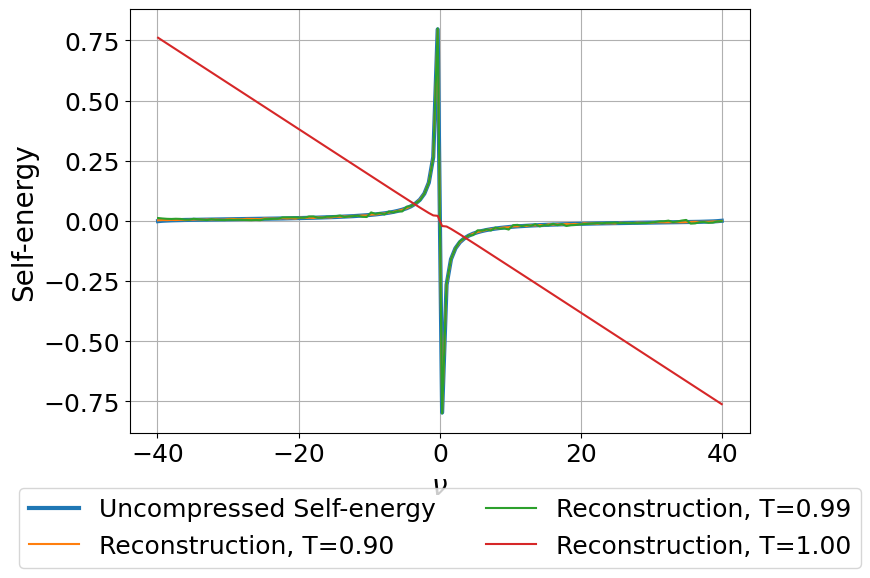

In [49]:
beta_value = 10
waveletbase = 'haar'

# Creating a temporary DataFrame where beta equals to the given beta_value and wavelet is the given waveletbase
temp_df = data[(data['beta'] == beta_value) & (data['wavelet'] == waveletbase)]

# Getting unique threshold values
thresholds = temp_df['threshold_quantile'].unique()

# Create a new plot
plt.figure(figsize=(8,5.5))

# Plot the selfenergy, as it's the same for all thresholds we only need to plot it once
v_values = temp_df['v'].iloc[0]  # Assuming v is same across all thresholds
selfenergy_values = temp_df['selfenergy'].iloc[0].imag  # Plotting only the real part, change as needed
plt.plot(v_values, selfenergy_values, label='Uncompressed Self-energy', linewidth=3)

# Looping over the unique threshold values
for threshold in thresholds:
    single_threshold_df = temp_df[temp_df['threshold_quantile'] == threshold]

    # Getting selfenergy_rec values
    selfenergy_rec_values = single_threshold_df['selfenergy_rec'].iloc[0].imag

    # Plotting selfenergy_rec
    plt.plot(v_values, selfenergy_rec_values, label=f'Reconstruction, T={threshold:.2f}')

# Set labels
plt.xlabel(r'$\nu$')
plt.ylabel('Self-energy')

plt.grid()

# Add a legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.show()